#  *Disposiciones solsticiales del complejo de petroglifos precolombinos de Tamesis, Colombia*
## Codigo Python utilizado

**Pablo C. Restrepo**
Institute of Physics
University of Antioquia
Medellín, Colombia
Corresponding author
pablo.cuartas@udea.edu.co


**Leidy A. Arias**
Institute of Physics
University of Antioquia
Medellín, Colombia
ljohanna.arango@udea.edu.co

**Manuel A. Izquierdo**
Centre d’Expertise Numérique pour la Recherche
Université de Montréal
Montreal, Canadá
ma.izquierdo@umontreal.ca


## Inicialización de datos
Para poder ejecutar y/o modificar el código, haga una copia del Notebook (click en "Copy To Drive") hacia su espacio personal de Google Drive y trabaje en esa copia.

**Importante!** Ejecute esta celda para cargar los archivos de datos desde GitHub

In [10]:
import os
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection
import numpy as np
import math
import xlrd
from shapely.geometry import LineString, Point

os.chdir('/content')
!git clone https://github.com/aizquier/tamesis_petroglyphs_data.git
os.chdir('tamesis_petroglyphs_data')

Cloning into 'tamesis_petroglyphs_data'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 5), reused 20 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), done.


Active la variable `write_to_pdf` a `True` si desea que las gráficas sean grabadas en formato .pdf

In [5]:
# * set to True in order to generate pdf files
#write_to_pdf = True
write_to_pdf = False

# Gráficas de los Acimutes petroglifos-farallones

Farallón Montenegro y Farallón la Pintada

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


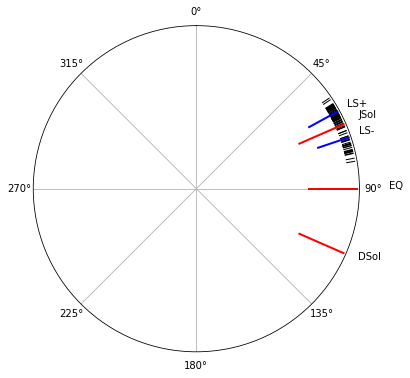

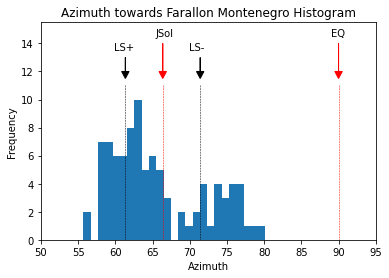

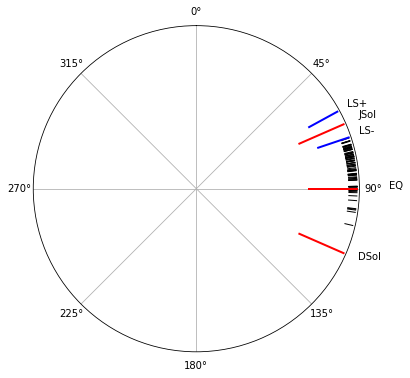

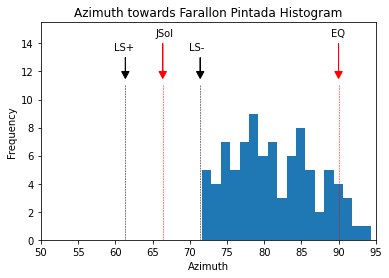

In [6]:
 for farallon in ['Montenegro', 'Pintada']:
    # azimuths to plot (degrees)
    
    data1=np.loadtxt('Azimut_%s.txt' % farallon)

    # convert to radians
    azimuths_rad1 = (np.array(data1) * np.pi) / 180.0
    
    # Polar plotting Montenegro
    fig = plt.figure(figsize = (6,6))  # Size
    plt.grid(color='#888888', linewidth=0.5)  # Color the grid
    ax = plt.subplot(111, polar=True)  # Create subplot
    ax.set_theta_direction(-1) # plot clockwise
    ax.set_theta_zero_location('N')  # Set zero to North
    ax.axes.get_yaxis().set_visible(False)
    for az in azimuths_rad1:
        ax.plot([az, az], [0.95, 1.0], color="#000000",linewidth=1)
    
    for az_sol, txt in [[66.37, 'JSol'], [90.0, 'EQ'], [(90.0 - 66.37) + 90.0, 'DSol']]:
        az_sol_r = math.radians(az_sol)
        ax.plot([az_sol_r, az_sol_r], [0.70, 1.0], color="#ff0000",linewidth=2)
        dtxt = 1.10 if az_sol != 90.0 else 1.20
        ax.text(az_sol_r, dtxt, txt)

    for az_moon, txt in [[61.34551268586746, 'LS+'], [71.40484083261919, 'LS-']]:
        az_moon_rad = math.radians(az_moon)
        ax.plot([az_moon_rad, az_moon_rad], [0.80, 1.0], color="#0000ff",linewidth=2)
        ax.text(az_moon_rad, 1.07, txt)

    if write_to_pdf:
        fig.savefig('azimuths_%s.pdf' % farallon, dpi=100, bbox_inches='tight')


    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for az_sol, txt in [[66.37, 'JSol'], [90.0, 'EQ']]: 
        ax.plot([az_sol, az_sol], [11, 0], color=(1, 0, 0), linewidth=0.5, linestyle='dashed')
        ax.arrow(az_sol,  14, 0, -2, color=(1, 0, 0), head_width=1, head_length=0.5)
        ax.text(az_sol-1, 14.5, txt)

    for az_moon, txt in [[61.34551268586746, 'LS+'], [71.40484083261919, 'LS-']]:
        ax.plot([az_moon, az_moon], [11, 0], color=(0, 0, 0), linewidth=0.5, linestyle='dashed')
        ax.arrow(az_moon,  13, 0, -1, color=(0, 0, 0), head_width=1, head_length=0.5)
        ax.text(az_moon-1.5, 13.5, txt)

    ax.set_xlim([50, 95])
    ax.set_ylim([0, 15.5])
    #_ = ax.hist(data1,normed=False, bins=25, )
    _ = ax.hist(data1, bins=25, )
    ax.set_title('Azimuth towards Farallon %s Histogram' % farallon)
    ax.set_xlabel('Azimuth')
    ax.set_ylabel('Frequency')

    if write_to_pdf:
        fig.savefig('azimuths_%s_histogram.pdf' % farallon, dpi=100, bbox_inches='tight')

# Gráficas de la proyección de los puntos de salida solar / lunar contra el perfil de los farallones

Definición del algoritmo principal (función `rise_projection_points()`) . Ejecutar primero.

In [7]:
def proj_line(x, y, th, d):
    xp = x + (d * math.cos(math.radians(90 - th)))
    yp = y + (d * math.sin(math.radians(90 - th)))
    return[(x,y), (xp, yp)]

def proj_line_symetric(x, y, th, d):
    p_up = proj_line(x , y, th, -d)
    p_down = proj_line(x , y, th, d)
    return (p_down[1], p_up[1])
    
def rise_projection_points(azimuth, title, filename):
    distance = 0.1343
    av_latitude = 5.692
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_xlabel('distance (metres)')
    ax.set_ylabel('altitude (metres)')
    ax.set_title(title)
    ax.set_ylim([400, 2000])
    figheight = 4 #in
    fig.set_size_inches(figheight*4.6, figheight)
    
    profile_line_coords = [(-75.622471832, 5.747756938), (-75.5950853862,5.6576040949)]
    profile_line = LineString(profile_line_coords)
    profile_start_point = Point(profile_line_coords[0])
    
    
    workbook = xlrd.open_workbook('petroglyphs_attr_table.xlsx')
    sheet = workbook.sheet_by_index(0)
    
    # extract id, vereda, name, lon, lat from the dataset
    data5 = [_m[0:3] + _m[8:10] + [_m[5]] for _m in [sheet.row_values(i) for i in range(sheet.nrows)][1:-1]]

    risepoints = []
    for petroglyph in data5:
        petroglyph_line = LineString(proj_line(petroglyph[3], petroglyph[4], azimuth, distance))
        intersection_point = profile_line.intersection(petroglyph_line)
        risepoints.append([profile_start_point.distance(intersection_point), petroglyph[5]])

    risepointsnp = np.array(risepoints)
    profile_data = np.loadtxt("profile_farallones_with_coordinates_epsg21897_longerline.csv", delimiter=',')
    
    profile_data_catet_lat = profile_data[:,[2,3]] # slices 3rd and 4th columns
    profile_data_catet_lat_1st_point =  profile_data_catet_lat[:,0][0] # * 111111.0
    profile_data_catet_lat -= [[ profile_data_catet_lat_1st_point, 0]]
    profile_data_catet_lat = np.fabs(profile_data_catet_lat)
    profile_data_catet_lat *=  [[111111.0, 1.0]]
    
    ax.plot( profile_data_catet_lat[:,0],  profile_data_catet_lat[:,1])
    petr_x = risepointsnp[:,0] * 111111
    petr_y = risepointsnp[:,1]
    ax.scatter(petr_x, petr_y, marker='+')
    profile_linestring = LineString([(p[0], p[1])  for p in profile_data_catet_lat])
    trajectory_lines = [LineString(proj_line_symetric(p[0]* 111111, p[1], av_latitude , 2000))  for p in risepoints ]
    
    mountain_risepoints = []
    for tlin in trajectory_lines:
        intersection = tlin.intersection(profile_linestring)
        if type(intersection) == Point:
            mountain_risepoints.append(intersection.coords[0])
        else:
            mountain_risepoints.append((None, None))
    
    mountain_risepoints = np.array(mountain_risepoints)
    mountain_risepoints_x = mountain_risepoints[:,0]
    mountain_risepoints_y = mountain_risepoints[:,1]
    
    ax.scatter(mountain_risepoints_x, mountain_risepoints_y, marker='o', color=(1, .2, 0))
    
    for i in range(len(risepointsnp)):
        x1 = risepoints[i][0] * 111111
        y1 = risepoints[i][1] 
        x2 = mountain_risepoints[i][0]
        y2 = mountain_risepoints[i][1]
        if x2 is not None:
            plt.plot([x1, x2], [y1, y2], linewidth=0.3, color=(0.5,0.5,0.5))
    
    
    if write_to_pdf:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

 Se llama a la función `rise_projection_points()` (definida enla celda anterior) para los casos de Solsticio de Junio, Equinoccio, y detenciones lunares


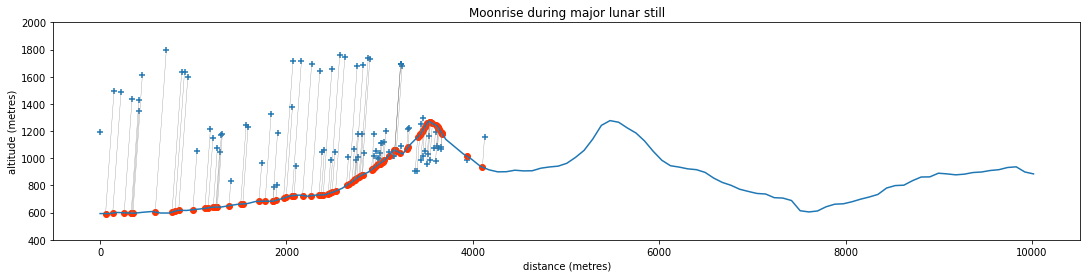

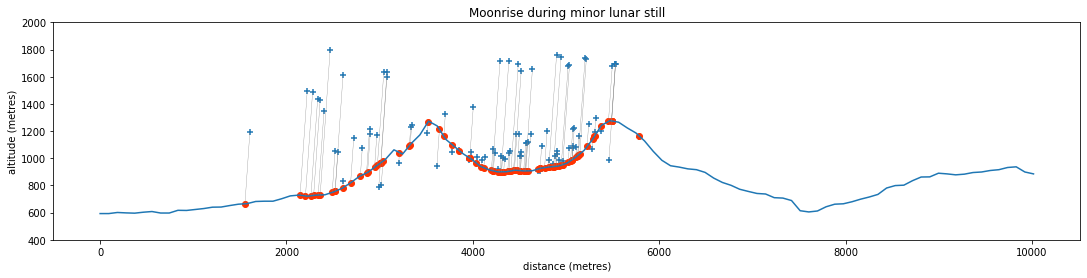

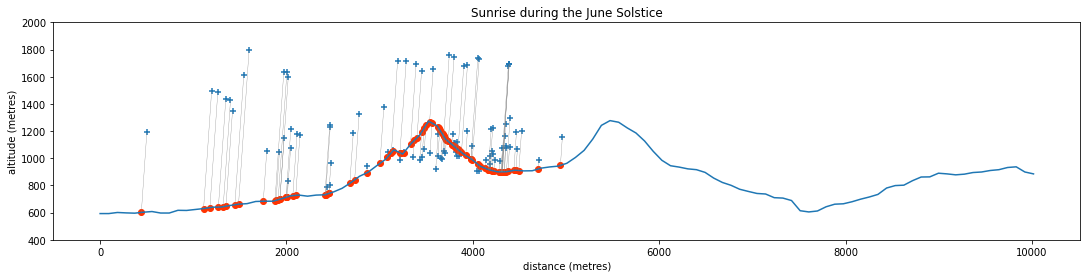

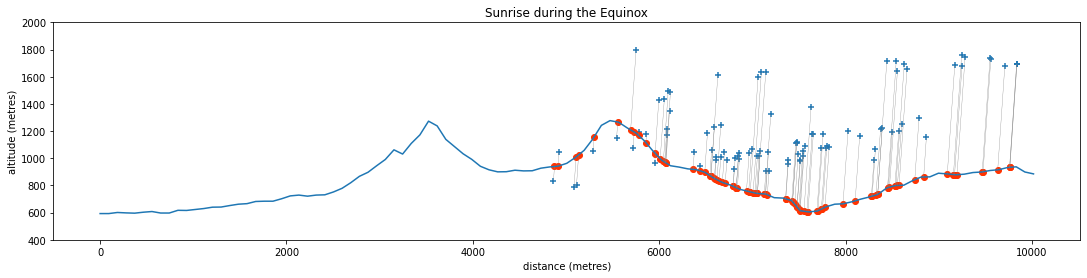

In [8]:
# * Acimut Detencion Lunar (Maxno norte)
majLST = 61.34551268586746

# * Acimut Detencion Lunar (Minimo sur)
minLST = 71.40484083261919

# * Acimut Solsticio Junio
solJune = 66.37631529801797

# * Acimut Equinoccio
solEqu = 90.0

np.set_printoptions(suppress=True)
rise_projection_points(majLST, 'Moonrise during major lunar still', 'moonrise_max_lunstill.pdf')
rise_projection_points(minLST, 'Moonrise during minor lunar still', 'moonrise_min_lunstill.pdf')
rise_projection_points(solJune,  'Sunrise during the June Solstice', 'sunrise_jun_solstice.pdf' )
rise_projection_points(solEqu,  'Sunrise during the Equinox', 'sunrise_equinox.pdf' )